### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Breast Cancer Image Dataset Ultrasound.zip" -d "/content"

Archive:  /content/drive/MyDrive/Breast Cancer Image Dataset Ultrasound.zip
replace /content/Dataset/benign/benign (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Dataset/benign/benign (1).png  
  inflating: /content/Dataset/benign/benign (1)_mask.png  
  inflating: /content/Dataset/benign/benign (10).png  
  inflating: /content/Dataset/benign/benign (10)_mask.png  
  inflating: /content/Dataset/benign/benign (100).png  
  inflating: /content/Dataset/benign/benign (100)_mask.png  
  inflating: /content/Dataset/benign/benign (100)_mask_1.png  
  inflating: /content/Dataset/benign/benign (101).png  
  inflating: /content/Dataset/benign/benign (101)_mask.png  
  inflating: /content/Dataset/benign/benign (102).png  
  inflating: /content/Dataset/benign/benign (102)_mask.png  
  inflating: /content/Dataset/benign/benign (103).png  
  inflating: /content/Dataset/benign/benign (103)_mask.png  
  inflating: /content/Dataset/benign/benign (104).png  
  inflating: /content

### Import Necessary Modules

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import sklearn
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
import tensorflow as tf

# Data Preprocessing

In [ ]:
# Set Image Properties
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Set path
path = 'Dataset/'

In [ ]:
size = 780 # Dataset size

In [ ]:
def k_means_conv(image):
    # convert to Gray Scale
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)

    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 4
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()
    
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image

In [ ]:
def SLIC(image):
  img = image
  #Initialize the slic item, the average size of super pixels is 20 (default is 10), and the smoothing factor is 20
  slic = cv2.ximgproc.createSuperpixelSLIC(img,region_size=20,ruler = 10.0) 
  slic.iterate(5)     #Number of iterations, the greater the better
  mask_slic = slic.getLabelContourMask() #Get Mask, Super pixel edge Mask==1
  label_slic = slic.getLabels()        #Get superpixel tags
  number_slic = slic.getNumberOfSuperpixels()  #Get the number of super pixels
  mask_inv_slic = cv2.bitwise_not(mask_slic)  
  img_slic = cv2.bitwise_and(img,img,mask =  mask_inv_slic) #Draw the superpixel boundary on the original image

  segmented_image = img_slic

  return segmented_image

In [ ]:
progress_bar = tqdm(total=size)  ### Progress bar init

####### Make Dataset ####

## Benign ###

BENIGN_SIZE = 437
BENIGN_IMAGE = np.zeros((BENIGN_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
BENIGN_MASK = np.zeros((BENIGN_SIZE, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
BENIGN = []

i = 1
N = 0
while i <= BENIGN_SIZE:
    # Load images
    img = cv2.imread(path + '/benign/' + 'benign (' + str(i) + ')' + '.png')
    # img = k_means_conv(img)
    img = SLIC(img)
    img = img_to_array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode = 'constant', preserve_range = True)
    
    # Load masks
    mask = img_to_array(cv2.imread(path + '/benign/' + 'benign (' + str(i) + ')_mask' + '.png'))
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)  
        
    BENIGN.append([
        img / 255.0,
        mask / 255.0,
        0, #'B'
    ])
    
    i += 1
    N += 1
    progress_bar.update(n=1)

BENIGN = pd.DataFrame(
    np.array(BENIGN),
    columns=['Image', 'Mask', 'Class']
)

#### Malignant ###

MALIGNANT_SIZE = 210
MALIGNANT_IMAGE = np.zeros((MALIGNANT_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
MALIGNANT_MASK = np.zeros((MALIGNANT_SIZE, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
MALIGNANT = []

i = 1
while i <= MALIGNANT_SIZE:
    # Load images
    img = cv2.imread(path + '/malignant/' + 'malignant (' + str(i) + ')' + '.png')
    # img = k_means_conv(img)
    # img = SLIC(img)
    img = img_to_array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(cv2.imread(path + '/malignant/' + 'malignant (' + str(i) + ')_mask' + '.png'))
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)  
        
    MALIGNANT.append([
        img / 255.0,
        mask / 255.0,
        1 #'M'
    ])
    
    i += 1
    N += 1
    progress_bar.update(n=1)

MALIGNANT = pd.DataFrame(
    data=np.array(MALIGNANT),
    columns=['Image', 'Mask', 'Class']
)
    
##### Normal #####

NORMAL_SIZE = 133
NORMAL_IMAGE = np.zeros((NORMAL_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
NORMAL_MASK = np.zeros((NORMAL_SIZE, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
NORMAL = []

i = 1
while i <= NORMAL_SIZE:
    # Load images
    img = cv2.imread(path + '/normal/' + 'normal (' + str(i) + ')' + '.png')
    # img = k_means_conv(img)
    # img = SLIC(img)
    img = img_to_array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(cv2.imread(path + '/normal/' + 'normal (' + str(i) + ')_mask' + '.png'))
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)  
        
    NORMAL.append([
        img / 255.0,
        mask / 255.0,
        -1 #'N'
    ])
    
    i += 1
    N += 1
    progress_bar.update(n=1)

NORMAL = pd.DataFrame(
    data=np.array(NORMAL), 
    columns=['Image', 'Mask', 'Class']
)

progress_bar.close()

  0%|          | 0/780 [00:00<?, ?it/s]

In [ ]:
df = pd.concat(
    [BENIGN, MALIGNANT, 
     NORMAL
     ],
    ignore_index=True,
    sort=False
)
df = sklearn.utils.shuffle(df)

In [ ]:
# df.head()

In [ ]:
X = df[['Image', 'Mask']]
y = df[['Class']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [ ]:
Z_train = X_train[['Mask']]
Z_test = X_test[['Mask']]

X_train.drop(['Mask'], inplace=True, axis=1)
X_test.drop(['Mask'], inplace=True, axis=1)

In [ ]:
# X_train.head()

In [ ]:
# Z_test.head()

In [ ]:
# y_train.head()

In [ ]:
# type(X_train)

In [ ]:
# X_train.shape

In [ ]:
X_test.shape

(156, 1)

In [ ]:
X_train_conv = np.zeros((X_train.shape[0], IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
i = 0 
for index, row in X_train.iterrows():
  X_train_conv[i] = row[0]
  i = i + 1

In [ ]:
X_test_conv = np.zeros((X_test.shape[0], IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
i = 0 
for index, row in X_test.iterrows():
  X_test_conv[i] = row[0]
  i = i + 1

In [ ]:
Z_train_conv = np.zeros((Z_train.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
i = 0 
for index, row in Z_train.iterrows():
  Z_train_conv[i] = row[0]
  i = i + 1

In [ ]:
Z_test_conv = np.zeros((Z_test.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
i = 0 
for index, row in Z_test.iterrows():
  Z_test_conv[i] = row[0]
  i = i + 1

In [ ]:
y_train_conv = np.zeros((y_train.shape[0], 1), dtype=np.int)
i = 0 
for index, row in y_train.iterrows():
  y_train_conv[i] = row[0]
  i = i + 1

In [ ]:
y_train_conv = np.where(y_train_conv == -1, 2, y_train_conv)

In [ ]:
y_test_conv = np.zeros((y_test.shape[0], 1), dtype=np.int)
i = 0 
for index, row in y_test.iterrows():
  y_test_conv[i] = row[0]
  i = i + 1

In [ ]:
y_test_conv = np.where(y_test_conv == -1, 2, y_test_conv)

In [ ]:
y_true = y_test_conv

In [ ]:
#  X_train_conv, X_test_val, Z_train_conv, Z_test_val = train_test_split(X_train_conv,  Z_train_conv, test_size=0.2, random_state=42)

# UNET

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
from tqdm import tqdm_notebook as tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

# from keras.utils import to_categorical
from keras.models import Model, load_model
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, InputLayer, Flatten, LeakyReLU, SeparableConv2D, Activation,Conv2D , MaxPool2D  , Dropout , BatchNormalization, concatenate, Conv2DTranspose, MaxPooling2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.callbacks import ReduceLROnPlateau


### UNET Model Build

In [ ]:
# Dice Co-efficient
from keras import backend as k
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = k.flatten(y_true)
    y_pred_f = k.flatten(y_pred)
    intersection = k.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (k.sum(y_true_f) + k.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Augment data.
# augmented = data_augmentation(s)

# Contraction path
c0 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
c0 = tf.keras.layers.Dropout(0.1)(c0)
c0 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c0)
p0 = tf.keras.layers.MaxPooling2D((2, 2))(c0)

c1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p0)
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.2)(c2)
c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.3)(c3)
c3 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c3)


#### Upsampling################### 
u8 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c3)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c9)

u10 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c0], axis=3)
c10 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c10)


outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c10)
 
segm = tf.keras.Model(inputs=[inputs], outputs=[outputs])
segm.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=["accuracy", dice_coef])
segm.summary()
################################
# Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('segmentation_model_for_breast_cancer_etoe.h5', monitor='val_dice_coef', mode='max', save_best_only=True)

callbacks = [
        checkpointer,
        tf.keras.callbacks.EarlyStopping(patience=200, monitor='val_dice_coef', mode="max"),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 128, 128, 64) 1792        lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 128, 128, 64) 0           conv2d_45[0][0]                  
____________________________________________________________________________________________

### UNET Model Training

#### Training UNET Segmentation Model

In [ ]:
segm_history = segm.fit(X_train_conv, Z_train_conv, epochs=300, callbacks=callbacks, validation_split=0.2, shuffle=True)

Epoch 1/300
16/16 [==============================] - 41s 2s/step - loss: 0.6589 - accuracy: 0.8826 - dice_coef: 0.1155 - val_loss: 0.5046 - val_accuracy: 0.9051 - val_dice_coef: 0.1132
Epoch 2/300
16/16 [==============================] - 9s 568ms/step - loss: 0.3571 - accuracy: 0.9096 - dice_coef: 0.0578 - val_loss: 0.4030 - val_accuracy: 0.9051 - val_dice_coef: 0.1040
Epoch 3/300
16/16 [==============================] - 9s 566ms/step - loss: 0.3001 - accuracy: 0.9096 - dice_coef: 0.0519 - val_loss: 0.3393 - val_accuracy: 0.9051 - val_dice_coef: 0.0970
Epoch 4/300
16/16 [==============================] - 9s 567ms/step - loss: 0.2697 - accuracy: 0.9096 - dice_coef: 0.0573 - val_loss: 0.3107 - val_accuracy: 0.9051 - val_dice_coef: 0.1027
Epoch 5/300
16/16 [==============================] - 9s 566ms/step - loss: 0.2410 - accuracy: 0.9096 - dice_coef: 0.0814 - val_loss: 0.2617 - val_accuracy: 0.9051 - val_dice_coef: 0.1299
Epoch 6/300
16/16 [==============================] - 9s 568ms/step 

In [ ]:
segm.save("SLIC_UNET.h5")

In [ ]:
segm.save("segmentation_model_for_breast_cancer_etoe.h5")

In [ ]:
all_segm = segm

In [ ]:
# from keras.models import load_model, load_weights
# segm_best = load_model("segmentation_model_for_breast_cancer_etoe.h5")
segm.load_weights("segmentation_model_for_breast_cancer_etoe.h5")

In [ ]:
segm.evaluate(X_test_conv, Z_test_conv)

5/5 [==============================] - 1s 162ms/step - loss: 0.3381 - accuracy: 0.8879 - dice_coef: 0.5547


[0.3380873501300812, 0.8878576755523682, 0.5546813607215881]

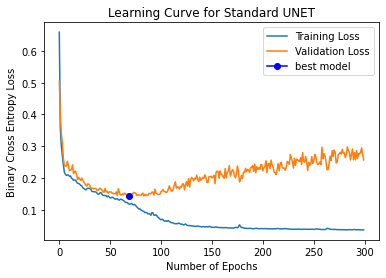

In [ ]:
plt.figure(figsize=(6, 4))
plt.title("Learning Curve for Standard UNET")
plt.plot(segm_history.history["loss"], label="Training Loss")
plt.plot(segm_history.history["val_loss"], label="Validation Loss")
plt.plot( np.argmin(segm_history.history["val_loss"]), np.min(segm_history.history["val_loss"]), marker="o", color="b", label="best model")
plt.xlabel("Number of Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend();

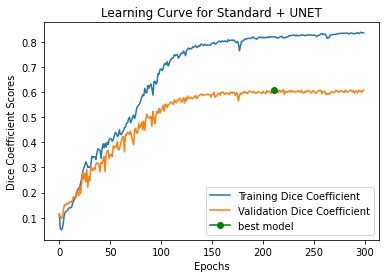

In [ ]:
plt.figure(figsize=(6, 4))
plt.title("Learning Curve for Standard + UNET")
plt.plot(segm_history.history["dice_coef"], label="Training Dice Coefficient")
plt.plot(segm_history.history["val_dice_coef"], label="Validation Dice Coefficient")
plt.plot( np.argmax(segm_history.history["val_dice_coef"]), np.max(segm_history.history["val_dice_coef"]), marker="o", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient Scores")
plt.legend();

# Classification Model (VGG 16 + Fully Connected Dense Layer)

In [ ]:
Z_train_clf = np.zeros((Z_train.shape[0], IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
i = 0
for index, row in Z_train.iterrows():
  Z_train_clf[i] = row[0]
  i = i + 1

In [ ]:
Z_train_clf_conv = np.zeros((Z_train_clf.shape[0], IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)

for index, element in enumerate(Z_train_clf):
  gray = cv2.cvtColor(Z_train_clf[index], cv2.COLOR_BGR2RGB)
  Z_train_clf_conv[index] = gray
  del gray

In [ ]:
# Z_train_clf_conv, Z_val_clf_conv, y_train_clf, y_val_clf = train_test_split(Z_train_clf_conv, y_train_conv, test_size=0.2, random_state=42)

In [ ]:
num_classes = 3

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train_conv = to_categorical(y_train_conv, num_classes)
y_test_conv = to_categorical(y_test_conv, num_classes)

In [ ]:
y_test_conv.shape

(156, 3)

In [ ]:
Z_train_conv.shape

(624, 128, 128, 1)

In [ ]:
pretrained_base = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=Z_train_clf_conv.shape[1:],
    pooling=max, classes=num_classes
)
pretrained_base.trainable = False

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.metrics import Precision
clf = keras.Sequential([
    pretrained_base,
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(2048, activation='tanh'),
    layers.Dense(1024, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='tanh'),
    layers.Dense(512, activation='tanh'),
    layers.Dense(3, activation='softmax'),
])

clf.compile(loss='categorical_crossentropy', 
            optimizer= keras.optimizers.Adam(learning_rate=0.0001), 
            metrics=['AUC','accuracy'])

In [ ]:
clf.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_34 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              16779264  
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)             

In [ ]:
################################
# Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('VGG16_Weights.h5', verbose=3, save_best_only=True)

callbacks = [
        checkpointer,
        tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss', mode='min'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [ ]:
history = clf.fit(Z_train_clf_conv, y_train_conv ,epochs=100, callbacks=callbacks, validation_split=0.2)

Epoch 1/100
16/16 [==============================] - 6s 297ms/step - loss: 0.7063 - auc: 0.8883 - accuracy: 0.7475 - val_loss: 0.1455 - val_auc: 0.9957 - val_accuracy: 0.9600

Epoch 00001: val_loss improved from inf to 0.14553, saving model to VGG16_Weights.h5
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.1688 - auc: 0.9906 - accuracy: 0.9539 - val_loss: 0.0579 - val_auc: 0.9990 - val_accuracy: 0.9840

Epoch 00002: val_loss improved from 0.14553 to 0.05790, saving model to VGG16_Weights.h5
Epoch 3/100
16/16 [==============================] - 2s 113ms/step - loss: 0.1033 - auc: 0.9963 - accuracy: 0.9719 - val_loss: 0.0772 - val_auc: 0.9966 - val_accuracy: 0.9760

Epoch 00003: val_loss did not improve from 0.05790
Epoch 4/100
16/16 [==============================] - 2s 132ms/step - loss: 0.0820 - auc: 0.9972 - accuracy: 0.9760 - val_loss: 0.0543 - val_auc: 0.9986 - val_accuracy: 0.9840

Epoch 00004: val_loss improved from 0.05790 to 0.05426, saving model to

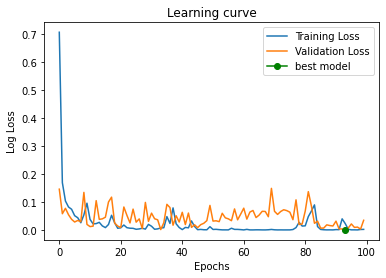

In [ ]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="o", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend();

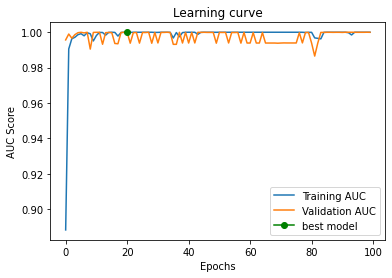

In [ ]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve")
plt.plot(history.history["auc"], label="Training AUC")
plt.plot(history.history["val_auc"], label="Validation AUC")
plt.plot(np.argmax(history.history["val_auc"]), np.max(history.history["val_auc"]), marker="o", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("AUC Score")
plt.legend();

In [ ]:
clf.save("VGG16 Classification Model.h5")

# Prediction Pipeline

In [ ]:
X_segm_pred_test = segm.predict(X_test_conv)

In [ ]:
X_segm_pred_test.shape

(156, 128, 128, 1)

In [ ]:
y_test_conv.shape

(156, 3)

In [ ]:
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

test_image_set = np.zeros((156, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

for index, image in enumerate(X_segm_pred_test):
  # color_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # gray_image = rgb2gray(color_image)
  # t = threshold_otsu(gray_image)
  # bg_image = gray_image > t
  # test_image_set[index] = cv2.cvtColor(np.float32(bg_image), cv2.COLOR_BGR2RGB)

  color_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  test_image_set[index] = color_image

In [ ]:
ind = 15

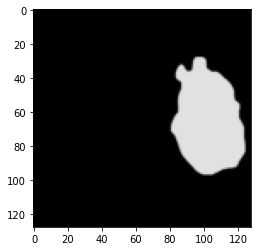

In [ ]:
plt.imshow(cv2.cvtColor(Z_test_conv[ind], cv2.COLOR_BGR2RGB))

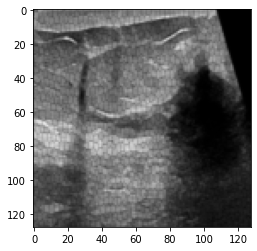

In [ ]:
plt.imshow(X_test_conv[ind])

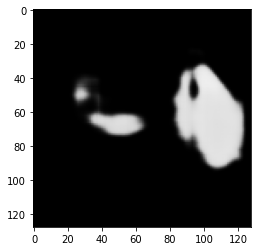

In [ ]:
plt.imshow(test_image_set[ind])

In [ ]:
# from keras.models import load_model
# clf = load_model("Final Classification Model.h5")

In [ ]:
# clf.evaluate(X_test_conv, y_test_conv)

In [ ]:
clf.evaluate(test_image_set, y_test_conv)

5/5 [==============================] - 2s 357ms/step - loss: 4.3262 - auc: 0.7744 - accuracy: 0.6795


[4.326202392578125, 0.7744185924530029, 0.6794871687889099]

In [ ]:
y_pred = clf.predict_classes(test_image_set)

AttributeError: ignored

In [ ]:
y_pred = np.argmax(clf.predict(test_image_set), axis=-1)

In [ ]:
# y_pred = clf.predict_classes(X_test_conv)

In [ ]:
# y_pred[100]

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
print(classification_report(y_true, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.66265   0.75342   0.70513        73
           1    0.63636   0.66038   0.64815        53
           2    0.88889   0.53333   0.66667        30

    accuracy                        0.67949       156
   macro avg    0.72930   0.64905   0.67331       156
weighted avg    0.69723   0.67949   0.67837       156



In [ ]:
# img = cv2.imread(path + '/normal/' + 'normal (' + str(50) + ')' + '.png')
# #img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
# img = SLIC(img)
# #img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode = 'constant', preserve_range = True)
# img = img / 255.0
# plt.imshow(img)

# SLIC K Means

In [ ]:
img = cv2.imread(path + '/normal/' + 'normal (' + str(20) + ')' + '.png')

(-0.5, 850.5, 686.5, -0.5)

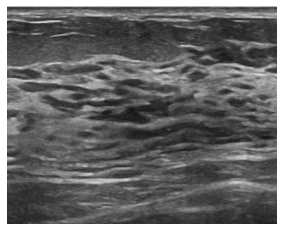

In [ ]:
plt.imshow(img)
plt.axis('off')

(-0.5, 850.5, 686.5, -0.5)

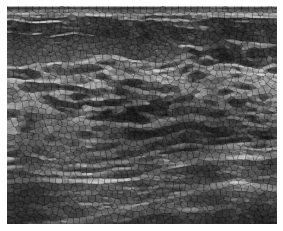

In [ ]:
plt.imshow(SLIC(img))
plt.axis('off')

(-0.5, 677.5, 570.5, -0.5)

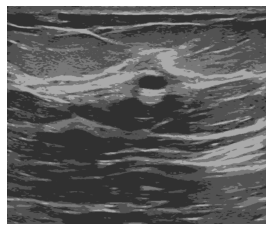

In [ ]:
plt.imshow(k_means_conv(img))
plt.axis('off')